<a href="https://colab.research.google.com/github/vkt1414/Cloud-Resources-Workflows/blob/main/Notebooks/Totalsegmentator/itkimage2segimageNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#This Notebook does the last step in the split workflow on Terra

The NIFTI files generated from Totalsegmentator are provided as input and the DICOM files are downloaded again to generate DICOM SEG Objects

Please cite:
Herz C, Fillion-Robin JC, Onken M, Riesmeier J, Lasso A, Pinter C, Fichtinger G, Pieper S, Clunie D, Kikinis R, Fedorov A. dcmqi: An Open Source Library for Standardized Communication of Quantitative Image Analysis Results Using DICOM. Cancer Res. 2017 Nov 1;77(21):e87-e90. doi: 10.1158/0008-5472.CAN-17-0336. PMID: 29092948; PMCID: PMC5675033.

In [1]:
import sys
from pathlib import Path
import time
curr_dir   = Path().absolute()

print(time.asctime(time.localtime()))
print("\nCurrent directory :{}".format( curr_dir))
print("Python version    :", sys.version.split('\n')[0])

Wed Apr  5 14:55:03 2023

Current directory :/content
Python version    : 3.9.16 (main, Dec  7 2022, 01:11:51) 


###Installing Packages

In [2]:
%%capture
#Installing lz4 for compression/decompression
#xvfb required for previewing Totalsegmentator png images
!apt-get install lz4 

In [3]:
%%capture
dcmqi_release_url = "https://github.com/QIICR/dcmqi/releases/download/v1.2.5/dcmqi-1.2.5-linux.tar.gz"
dcmqi_download_path = f"{curr_dir}/dcmqi-1.2.5-linux.tar.gz"
dcmqi_path = f"{curr_dir}/dcmqi-1.2.5-linux"

!wget -O $dcmqi_download_path $dcmqi_release_url

!tar -xvf $dcmqi_download_path 

!mv $dcmqi_path/bin/* /bin
!rm -r $dcmqi_download_path $dcmqi_path

In [4]:
%%capture
#install s5cmd
!wget "https://github.com/peak/s5cmd/releases/download/v2.0.0/s5cmd_2.0.0_Linux-64bit.tar.gz"
!tar -xvzf "s5cmd_2.0.0_Linux-64bit.tar.gz"
!rm "s5cmd_2.0.0_Linux-64bit.tar.gz"
!mv s5cmd /usr/local/bin/s5cmd

###Parameters

In [5]:
csvFilePath=''
inferenceNiftiFilePath=''

###Extracting Inference NIFTI files

In [6]:
import shutil
import glob
import os
try:
  shutil.rmtree(f'Inference')
except OSError:
  pass

#Get the file path of the inferenceNiftiFiles
!wget https://github.com/vkt1414/Cloud-Resources-Workflows/raw/main/sampleManifests/inferenceNiftiFiles.tar.lz4

inferenceNiftiFilePath = glob.glob('*.tar.lz4')[0]
!lz4 -d {inferenceNiftiFilePath} -c | tar --strip-components=0 -xvf -

#!lz4 -d /content/drive/MyDrive/idc_vamsi/inferenceNiftiFiles.tar.lz4 -c | tar xvf -

--2023-04-05 14:55:20--  https://github.com/vkt1414/Cloud-Resources-Workflows/raw/main/sampleManifests/inferenceNiftiFiles.tar.lz4
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/vkt1414/Cloud-Resources-Workflows/main/sampleManifests/inferenceNiftiFiles.tar.lz4 [following]
--2023-04-05 14:55:21--  https://raw.githubusercontent.com/vkt1414/Cloud-Resources-Workflows/main/sampleManifests/inferenceNiftiFiles.tar.lz4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4234084 (4.0M) [application/octet-stream]
Saving to: ‘inferenceNiftiFiles.tar.lz4’

inferenceNiftiFiles 100%[===================>]   4.04M

###Reading CSV File containing s5cmd Urls

In [7]:
import sys
import time
import pandas as pd
from pathlib import Path

In [8]:
#get the path of the zip file containing csv file in the current working directory
#In Terra, a zip file containing the csv file will be provided as input and will be localized
#to the current working directory.

#Since it will be the only zip file that will be provided as input, we will be unzipping 
#the first zip file in the current working directory.

import glob
!wget https://raw.githubusercontent.com/vkt1414/Cloud-Resources-Workflows/main/sampleManifests/batch_1.csv

csvFilePath = glob.glob('*.csv')[0]
#zip_file_path='/content/drive/MyDrive/result.zip'
#!unzip $zip_file_path

#csv_file_path = glob.glob('*.csv')[0]
#csv_file_path= '/home/vamsi/Downloads/result.csv'

start_time = time.time()
#cohort_df=pd.read_csv(csv_file_path, delimiter=',', encoding='utf-8')
#cohort_df= pd.read_csv('/content/drive/MyDrive/bquxjob_7f0d87d5_187056e0dd3.csv') #two nifti files example
#cohort_df= pd.read_csv('/content/drive/MyDrive/bq-results-20230315-160529-1678896367937/bq-results-20230315-160529-1678896367937.csv')
cohort_df=pd.read_csv(csvFilePath, delimiter=',', encoding='utf-8')
read_time=time.time() -start_time
print('read in '+str(read_time)+ '  seconds')  

--2023-04-05 14:55:23--  https://raw.githubusercontent.com/vkt1414/Cloud-Resources-Workflows/main/sampleManifests/batch_1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139861 (137K) [text/plain]
Saving to: ‘batch_1.csv’

batch_1.csv         100%[===================>] 136.58K  --.-KB/s    in 0.02s   

2023-04-05 14:55:24 (7.68 MB/s) - ‘batch_1.csv’ saved [139861/139861]

read in 0.018119335174560547  seconds


###Functions

In [9]:
try:
  shutil.rmtree(f'itkimage2segimage')
except OSError:
  pass
os.mkdir(f'itkimage2segimage')

In [10]:
from concurrent.futures import ThreadPoolExecutor
from time import sleep
from datetime import datetime
import psutil
import time
import pandas as pd
import matplotlib.pyplot as plt

class MemoryMonitor:
    def __init__(self):
        self.keep_measuring = True

    def measure_usage(self):
        cpu_usage = []
        ram_usage_mb=[]
        disk_usage_all=[]
        time_stamps = []
        start_time = time.time()
        while self.keep_measuring:
            cpu = psutil.cpu_percent()
            ram = psutil.virtual_memory()
            disk_used= psutil.disk_usage('/').used/1024/1024/1024
            disk_total= psutil.disk_usage('/').total/1024/1024/1024
            ram_total_mb = psutil.virtual_memory().total / 1024 / 1024
            ram_mb = (ram.total - ram.available) / 1024 / 1024

            cpu_usage.append(cpu)
            ram_usage_mb.append(ram_mb)
            disk_usage_all.append(disk_used)

            time_stamps.append(time.time()- start_time)
            sleep(1)

        return cpu_usage, ram_usage_mb, time_stamps, ram_total_mb,  disk_usage_all, disk_total

In [11]:
def download_dicom_data(series_id):

  """
  Download raw DICOM data into "idc_data" folder.

  """
  try:
    shutil.rmtree(f'idc_data/{series_id}')
  except OSError:
    pass
  global cohort_df
  gs_file_path = "s5cmd_manifest.txt"
  #when bigquery is used the following line could be used
  #cohort_df = bq_client.query(selection_query).to_dataframe()
  series_df=cohort_df[cohort_df['SeriesInstanceUID']==series_id]
  series_df["s5cmdUrls"].to_csv(gs_file_path, header = False, index = False)
  #remove double quotes from the manifest file
  !sed -i 's/"//g' s5cmd_manifest.txt  

  start_time = time.time()
  print("Copying files from IDC buckets..")

  !s5cmd --no-sign-request --endpoint-url https://storage.googleapis.com run s5cmd_manifest.txt  >> /dev/null

  elapsed = time.time() - start_time
  print("Done in %g seconds."%elapsed)

In [12]:
try:
  os.remove(f'{curr_dir}/dicomseg_metadata_whole.json')
except OSError:
  pass
!wget https://raw.githubusercontent.com/vkt1414/models/main/models/totalsegmentator/config/dicomseg_metadata_whole.json

--2023-04-05 14:55:24--  https://raw.githubusercontent.com/vkt1414/models/main/models/totalsegmentator/config/dicomseg_metadata_whole.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80391 (79K) [text/plain]
Saving to: ‘dicomseg_metadata_whole.json’

dicomseg_metadata_w 100%[===================>]  78.51K  --.-KB/s    in 0.01s   

2023-04-05 14:55:27 (5.35 MB/s) - ‘dicomseg_metadata_whole.json’ saved [80391/80391]



In [13]:
def itkimage2segimage(series_id):
      try:
        shutil.rmtree(f'itkimage2segimage/{series_id}')
      except OSError:
        pass
        os.mkdir(f'itkimage2segimage/{series_id}')

      print("Processing series: "+series_id)  

      """
      Downloading DICOM files only for the Series with Totalsegmentator NIFTI files

      """
      download_dicom_data(series_id) 


      #Get Inference NIFTI file path
      inference_nifti_filename_path = os.path.join(curr_dir,'Inference', series_id, series_id+'.nii.lz4')
      inference_nifti_filename = os.path.join(curr_dir,'Inference', series_id, series_id+'.nii')
      inference_list = []
      inference_list.append(inference_nifti_filename)

      try:
        os.remove(inference_nifti_filename)
      except OSError:
        pass
      !lz4 -d {inference_nifti_filename_path}
      #remove the compressed file after decompressing
      !rm -r {inference_nifti_filename_path}
       
      start_time = time.time()
      !itkimage2segimage --inputImageList {inference_nifti_filename} --inputDICOMDirectory {curr_dir}/idc_data/ --outputDICOM {curr_dir}/itkimage2segimage/{series_id}/{series_id}.dcm --inputMetadata {curr_dir}/dicomseg_metadata_whole.json --skip >> /dev/null
      itkimage2segimage_time = time.time() - start_time
      print("Done in %g seconds."%itkimage2segimage_time)
      
      check_itkimage_errors(series_id)

      start_time = time.time()     
      !lz4 {curr_dir}/itkimage2segimage/{series_id}/{series_id}.dcm  {curr_dir}/itkimage2segimage/{series_id}/{series_id}.dcm.lz4
      archiving_time = time.time() - start_time
      
      log = pd.DataFrame({'SeriesInstanceUID': [series_id]}) 
      log['itkimage2segimage_time']=itkimage2segimage_time
      log['archiving_time'] = archiving_time

      !rm -r {curr_dir}/Inference/{series_id}
      !rm -r {curr_dir}/idc_data
      !rm -r {curr_dir}/itkimage2segimage/{series_id}/{series_id}.dcm
      global runtime_stats
      runtime_stats = pd.concat([runtime_stats, log], ignore_index=True, axis=0)

In [14]:
def remove_directories_without_nii_files(path):
    for dirpath, dirnames, filenames in os.walk(path):
        if dirpath != path and not any(filename.endswith('.nii.lz4') for filename in filenames):
            os.rmdir(dirpath)

In [15]:
#removing empty directories
remove_directories_without_nii_files(os.path.join(curr_dir,'Inference/'))

In [16]:
def check_itkimage_errors(series_id):
    try:
        # Check if the output file from itkimage2segimage exists
        assert os.path.exists(f"{curr_dir}/itkimage2segimage/{series_id}/{series_id}.dcm")
    except AssertionError:
        # If the output file does not exist, log an error
        with open('itkimage2segimage_error_file.txt', 'a') as f:
            f.write(f"Error: itkimage2segimage failed for series {series_id}\n")
        return True
    return False

###Convert Inference NIFTI file to DICOM_SEG Object

Processing series: 1.2.840.113654.2.55.22770087029972268579113866309746562015
Copying files from IDC buckets..
Done in 0.618254 seconds.
Decoding file /content/Inference/1.2.840.113654.2.55.22770087029972268579113866309746562015/1.2.840.113654.2.55.22770087029972268579113866309746562015.nii 
/content/Inference/1 : decoded 33566144 bytes 
Done in 6.65046 seconds.
Compressed 82696872 bytes into 701725 bytes ==> 0.85%


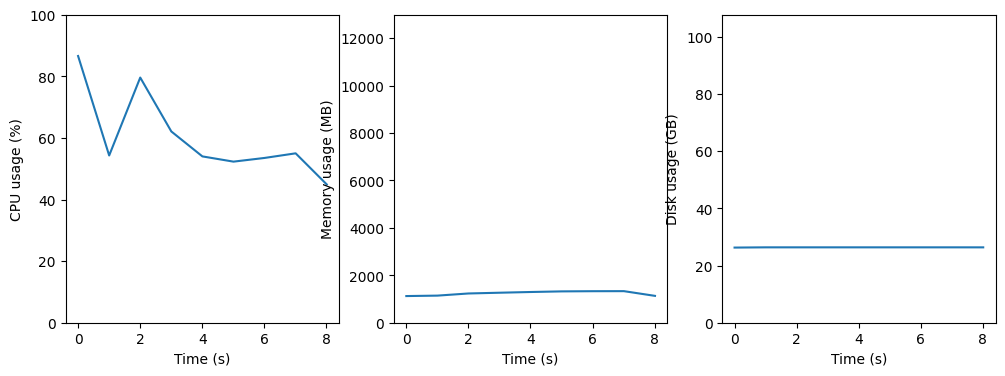

Processing series: 1.2.840.113654.2.55.146601594654322994982630019583270053397
Copying files from IDC buckets..
Done in 0.728616 seconds.
Decoding file /content/Inference/1.2.840.113654.2.55.146601594654322994982630019583270053397/1.2.840.113654.2.55.146601594654322994982630019583270053397.nii 
/content/Inference/1 : decoded 36449728 bytes 
Done in 7.9515 seconds.
Compressed 96363692 bytes into 767048 bytes ==> 0.80%


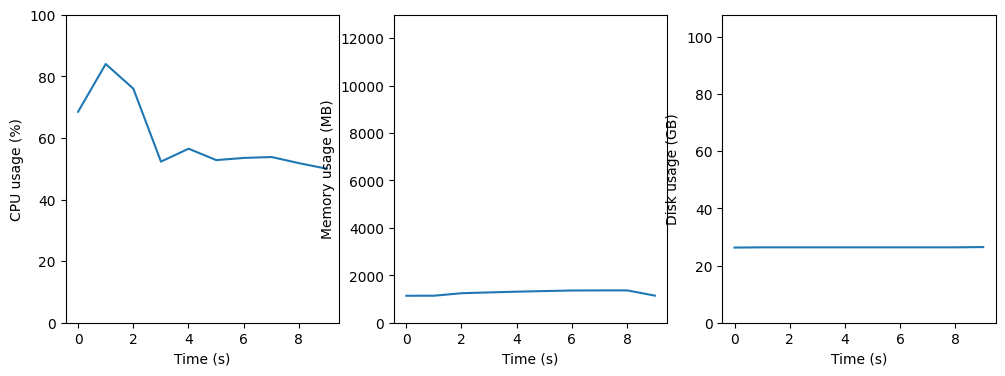

Processing series: 1.2.840.113654.2.55.14382674871619950799472325766084940706
Copying files from IDC buckets..
Done in 0.620733 seconds.
Decoding file /content/Inference/1.2.840.113654.2.55.14382674871619950799472325766084940706/1.2.840.113654.2.55.14382674871619950799472325766084940706.nii 
/content/Inference/1 : decoded 31993280 bytes 
Done in 7.35831 seconds.
Compressed 80962438 bytes into 677897 bytes ==> 0.84%


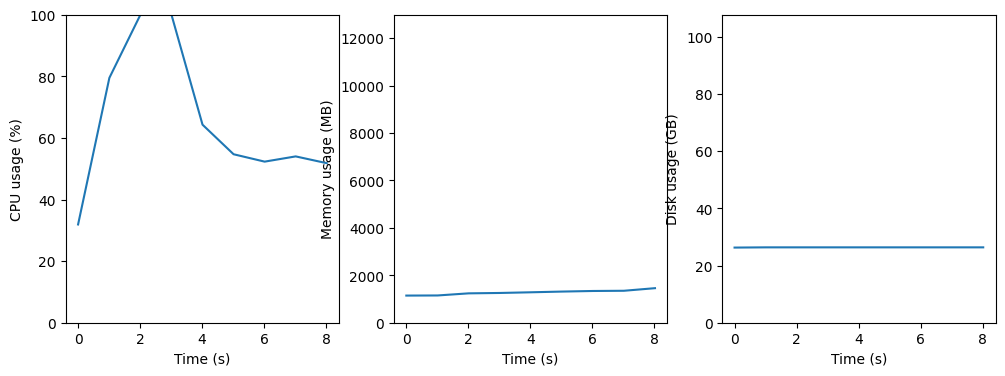

Processing series: 1.2.840.113654.2.55.100875189782210690344207306235124901243
Copying files from IDC buckets..
Done in 0.51946 seconds.
Decoding file /content/Inference/1.2.840.113654.2.55.100875189782210690344207306235124901243/1.2.840.113654.2.55.100875189782210690344207306235124901243.nii 
/content/Inference/1 : decoded 35401152 bytes 
Done in 8.66009 seconds.
Compressed 93062958 bytes into 767938 bytes ==> 0.83%


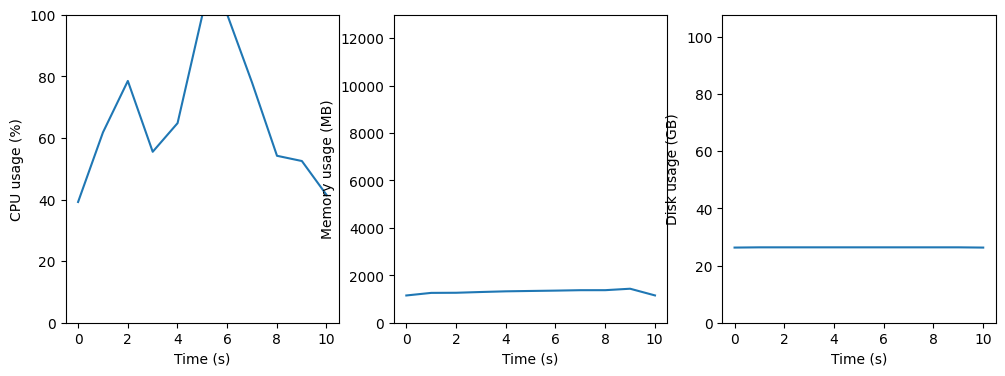

Processing series: 1.2.840.113654.2.55.216614002338888733987350522981366678482
Copying files from IDC buckets..
Done in 0.52095 seconds.
Decoding file /content/Inference/1.2.840.113654.2.55.216614002338888733987350522981366678482/1.2.840.113654.2.55.216614002338888733987350522981366678482.nii 
/content/Inference/1 : decoded 34090432 bytes 
Done in 8.35359 seconds.
Compressed 87963040 bytes into 730241 bytes ==> 0.83%


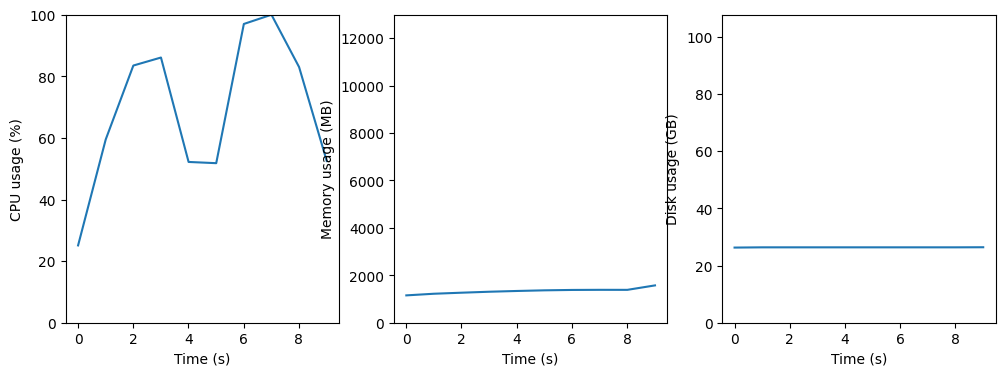

Processing series: 1.2.840.113654.2.55.113040386178547843571271236478024341696
Copying files from IDC buckets..
Done in 0.629713 seconds.
Decoding file /content/Inference/1.2.840.113654.2.55.113040386178547843571271236478024341696/1.2.840.113654.2.55.113040386178547843571271236478024341696.nii 
/content/Inference/1 : decoded 50081216 bytes 
Done in 14.3808 seconds.
Compressed 136898018 bytes into 1026486 bytes ==> 0.75%


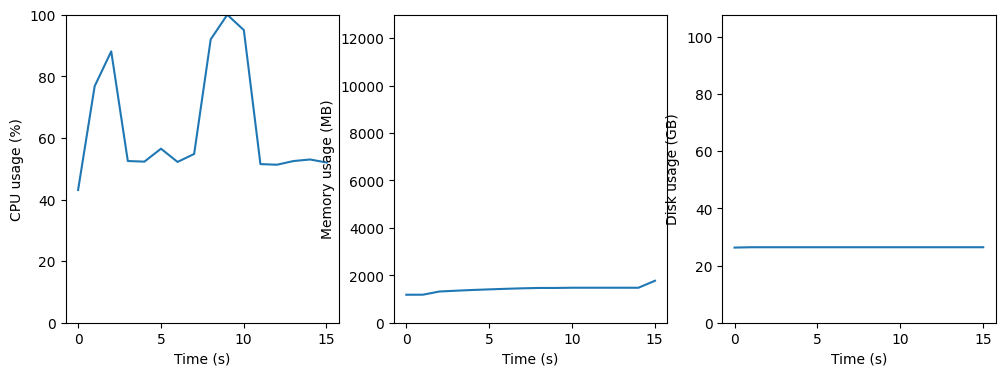

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.431377773401197924485551006033
Copying files from IDC buckets..
Done in 0.626863 seconds.
Decoding file /content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.431377773401197924485551006033/1.3.6.1.4.1.14519.5.2.1.7009.9004.431377773401197924485551006033.nii 
/content/Inference/1 : decoded 30158272 bytes 
Done in 7.6546 seconds.
Compressed 82929346 bytes into 644745 bytes ==> 0.78%


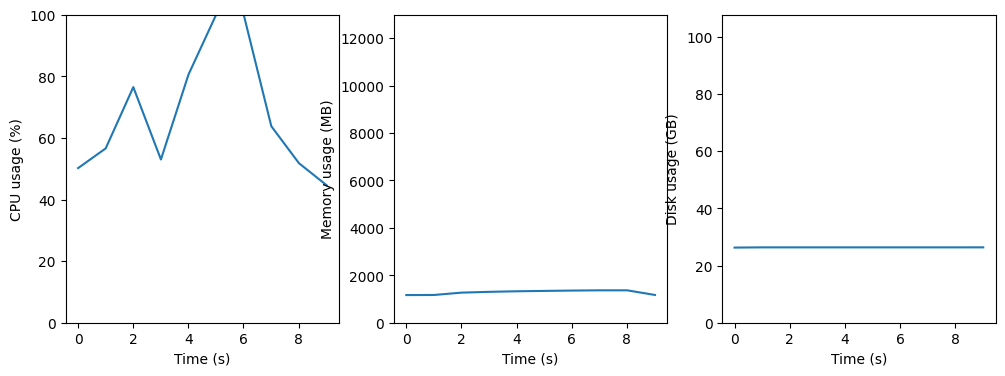

Processing series: 1.2.840.113654.2.55.154809705591242159075253605419469935510
Copying files from IDC buckets..
Done in 0.623289 seconds.
Decoding file /content/Inference/1.2.840.113654.2.55.154809705591242159075253605419469935510/1.2.840.113654.2.55.154809705591242159075253605419469935510.nii 
/content/Inference/1 : decoded 29371840 bytes 
Done in 6.1507 seconds.
Compressed 71329104 bytes into 564316 bytes ==> 0.79%


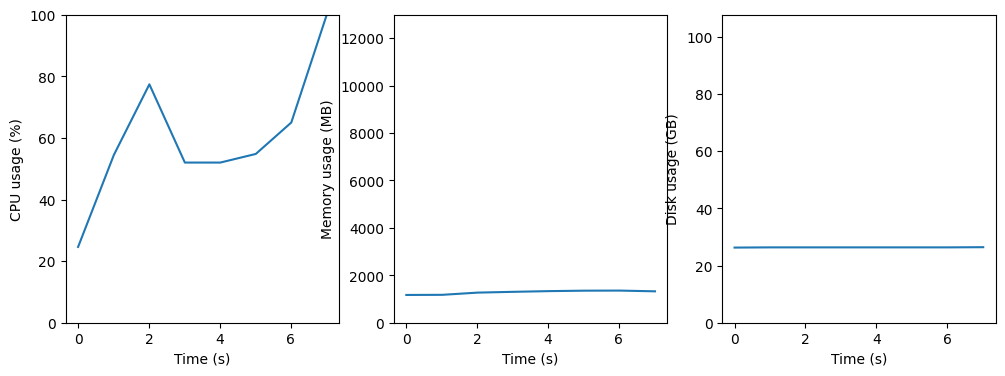

Processing series: 1.2.840.113654.2.55.243990451406006403331425809632881193215
Copying files from IDC buckets..
Done in 0.627712 seconds.
Decoding file /content/Inference/1.2.840.113654.2.55.243990451406006403331425809632881193215/1.2.840.113654.2.55.243990451406006403331425809632881193215.nii 
/content/Inference/1 : decoded 47197632 bytes 
Done in 12.0068 seconds.
Compressed 123664784 bytes into 952055 bytes ==> 0.77%


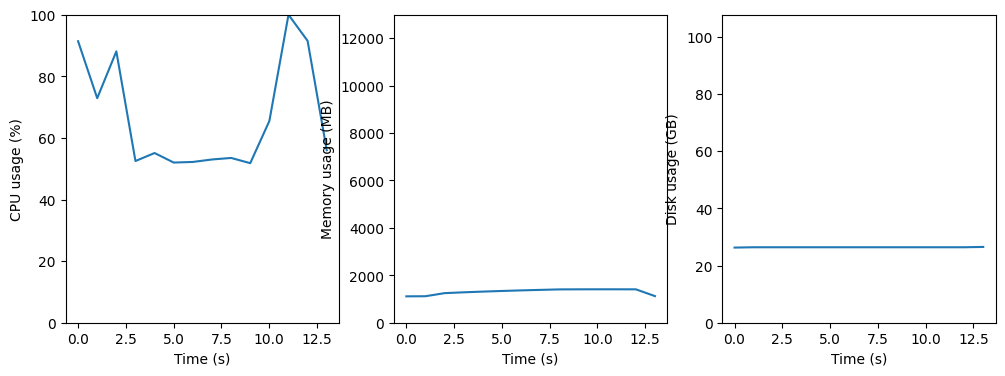

Processing series: 1.2.840.113654.2.55.185309182591805634517860395342326800332
Copying files from IDC buckets..
Done in 0.62201 seconds.
Decoding file /content/Inference/1.2.840.113654.2.55.185309182591805634517860395342326800332/1.2.840.113654.2.55.185309182591805634517860395342326800332.nii 
/content/Inference/1 : decoded 41430464 bytes 
Done in 11.0677 seconds.
Compressed 117549786 bytes into 886292 bytes ==> 0.75%


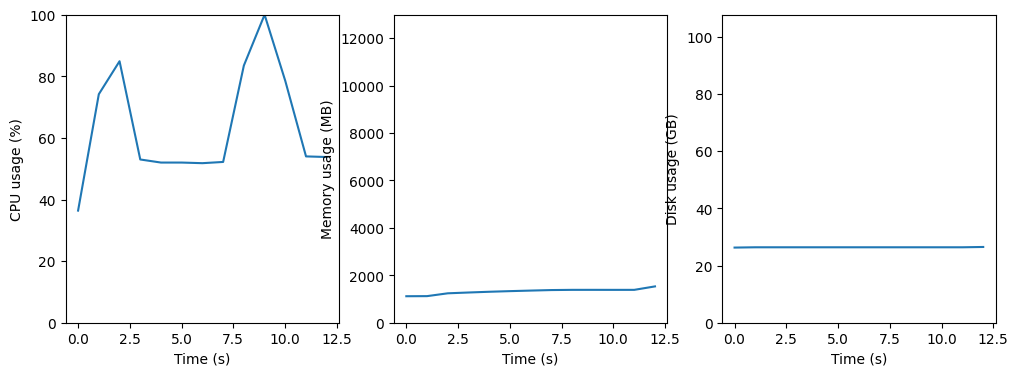

In [17]:

runtime_stats = pd.DataFrame(columns=['SeriesInstanceUID','itkimage2segimage_time',
                                      'archiving_time', 'cpu_usage','ram_usage_mb', 'ram_total_mb', 
                                      'disk_usage_all', 'disk_total'
                                      ])
if __name__ == "__main__":
    for series_id in os.listdir(f'Inference'):
        with ThreadPoolExecutor() as executor:
            monitor = MemoryMonitor()
            mem_thread = executor.submit(monitor.measure_usage)
            try:
                proc_thread = executor.submit(itkimage2segimage, series_id)
                proc_thread.result()
            finally:
                monitor.keep_measuring = False
                cpu_usage, ram_usage_mb, time_stamps, ram_total_mb, disk_usage_all, disk_total= mem_thread.result()
                
                cpu_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[cpu_idx, runtime_stats.columns.get_loc('cpu_usage')] = [[cpu_usage]]

                ram_usage_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[ram_usage_mb_idx, runtime_stats.columns.get_loc('ram_usage_mb')] = [[ram_usage_mb]]
                
                ram_total_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[ram_total_mb_idx, runtime_stats.columns.get_loc('ram_total_mb')] = [[ram_total_mb]]

                disk_usage_gb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[disk_usage_gb_idx, runtime_stats.columns.get_loc('disk_usage_all')] = [[disk_usage_all]]

                runtime_stats['disk_total']=disk_total    

                fig, ((ax1,ax2, ax3)) = plt.subplots(1,3, figsize=(12, 4)) 

                ax1.plot(time_stamps, cpu_usage)
                ax1.set_ylim(0, 100)
                ax1.set_xlabel('Time (s)')
                ax1.set_ylabel('CPU usage (%)')

                ax2.plot(time_stamps, ram_usage_mb)
                ax2.set_ylim(0, ram_total_mb)
                ax2.set_xlabel('Time (s)')
                ax2.set_ylabel('Memory usage (MB)')

                ax3.plot(time_stamps, disk_usage_all)
                ax3.set_ylim(0, disk_total)
                ax3.set_xlabel('Time (s)')
                ax3.set_ylabel('Disk usage (GB)')
                plt.show()

###Compressing Output Files

In [18]:
start_time = time.time()
try:
  os.remove(f'{curr_dir}/itkimage2segimageDICOMsegFiles.tar.lz4')
except OSError:
  pass
!tar cvf - {curr_dir}/itkimage2segimage | lz4 > {curr_dir}/itkimage2segimageDICOMsegFiles.tar.lz4
output_archiving_time = time.time() - start_time

tar: Removing leading `/' from member names
/content/itkimage2segimage/
/content/itkimage2segimage/1.2.840.113654.2.55.22770087029972268579113866309746562015/
/content/itkimage2segimage/1.2.840.113654.2.55.22770087029972268579113866309746562015/1.2.840.113654.2.55.22770087029972268579113866309746562015.dcm.lz4
/content/itkimage2segimage/1.2.840.113654.2.55.146601594654322994982630019583270053397/
/content/itkimage2segimage/1.2.840.113654.2.55.146601594654322994982630019583270053397/1.2.840.113654.2.55.146601594654322994982630019583270053397.dcm.lz4
/content/itkimage2segimage/1.2.840.113654.2.55.14382674871619950799472325766084940706/
/content/itkimage2segimage/1.2.840.113654.2.55.14382674871619950799472325766084940706/1.2.840.113654.2.55.14382674871619950799472325766084940706.dcm.lz4
/content/itkimage2segimage/1.2.840.113654.2.55.100875189782210690344207306235124901243/
/content/itkimage2segimage/1.2.840.113654.2.55.100875189782210690344207306235124901243/1.2.840.113654.2.55.1008751897

###Utilization Metrics

In [19]:
runtime_stats.to_csv('runtime.csv')
runtime_stats['output_archiving_time']=output_archiving_time
try:
  os.remove('itkimage2segimageUsageMetrics.lz4')
except OSError:
  pass
!lz4 {curr_dir}/runtime.csv itkimage2segimageUsageMetrics.lz4
runtime_stats

Compressed 6053 bytes into 2989 bytes ==> 49.38%


,SeriesInstanceUID,itkimage2segimage_time,archiving_time,cpu_usage,ram_usage_mb,ram_total_mb,disk_usage_all,disk_total,output_archiving_time
0,1.2.840.113654.2.55.22770087029972268579113866...,6.650459,0.120711,"[[[86.6, 54.3, 79.6, 62.1, 54.0, 52.3, 53.5, 5...","[[[1124.0546875, 1142.69140625, 1233.15234375,...",[12985.546875],"[[[26.279193878173828, 26.362281799316406, 26....",107.715084,0.128629
1,1.2.840.113654.2.55.14660159465432299498263001...,7.951503,0.120082,"[[[68.5, 84.0, 76.0, 52.3, 56.5, 52.8, 53.5, 5...","[[[1136.4296875, 1139.1171875, 1243.47265625, ...",[12985.546875],"[[[26.279098510742188, 26.366268157958984, 26....",107.715084,0.128629
2,1.2.840.113654.2.55.14382674871619950799472325...,7.358307,0.119659,"[[[31.9, 79.5, 100.0, 100.0, 64.3, 54.7, 52.3,...","[[[1144.43359375, 1149.26171875, 1238.4375, 12...",[12985.546875],"[[[26.279102325439453, 26.358501434326172, 26....",107.715084,0.128629
3,1.2.840.113654.2.55.10087518978221069034420730...,8.660091,0.115205,"[[[39.2, 61.8, 78.5, 55.5, 64.8, 100.0, 100.0,...","[[[1148.87109375, 1257.91796875, 1262.921875, ...",[12985.546875],"[[[26.27899932861328, 26.365642547607422, 26.3...",107.715084,0.128629
4,1.2.840.113654.2.55.21661400233888873398735052...,8.353585,0.127741,"[[[25.1, 59.5, 83.5, 86.1, 52.2, 51.8, 97.0, 1...","[[[1152.953125, 1221.94140625, 1265.83203125, ...",[12985.546875],"[[[26.278945922851562, 26.364391326904297, 26....",107.715084,0.128629
5,1.2.840.113654.2.55.11304038617854784357127123...,14.380830,0.121757,"[[[43.1, 76.8, 88.1, 52.5, 52.3, 56.5, 52.2, 5...","[[[1179.6171875, 1181.41796875, 1315.9453125, ...",[12985.546875],"[[[26.278804779052734, 26.399486541748047, 26....",107.715084,0.128629
6,1.3.6.1.4.1.14519.5.2.1.7009.9004.431377773401...,7.654605,0.120676,"[[[50.2, 56.6, 76.5, 53.0, 80.6, 100.0, 100.0,...","[[[1165.80078125, 1169.70703125, 1268.75390625...",[12985.546875],"[[[26.278812408447266, 26.353286743164062, 26....",107.715084,0.128629
7,1.2.840.113654.2.55.15480970559124215907525360...,6.150705,0.367079,"[[[24.6, 54.5, 77.4, 52.0, 52.0, 54.8, 65.0, 1...","[[[1170.67578125, 1175.94140625, 1269.32421875...",[12985.546875],"[[[26.278732299804688, 26.351116180419922, 26....",107.715084,0.128629
8,1.2.840.113654.2.55.24399045140600640333142580...,12.006764,0.121815,"[[[91.4, 72.9, 88.1, 52.5, 55.1, 52.0, 52.2, 5...","[[[1112.546875, 1116.81640625, 1247.1328125, 1...",[12985.546875],"[[[26.278522491455078, 26.39275360107422, 26.3...",107.715084,0.128629
9,1.2.840.113654.2.55.18530918259180563451786039...,11.067739,0.120980,"[[[36.4, 74.2, 84.9, 53.0, 52.0, 52.0, 51.8, 5...","[[[1116.9375, 1121.0546875, 1240.08984375, 127...",[12985.546875],"[[[26.27838897705078, 26.382205963134766, 26.3...",107.715084,0.128629
